# A Guide to Mixed HMC

## Mixed HMC implementation in numpyro

In [1]:
import arviz as az
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import DiscreteHMCGibbs, HMC, MCMC, MixedHMC, NUTS

In [2]:
def model(probs, locs):
     c = numpyro.sample("c", dist.Categorical(probs))
     numpyro.sample("x", dist.Normal(locs[c], 0.5))
    
probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])

### Mixed HMC

In [3]:
kernel = MixedHMC(HMC(model, trajectory_length=1.2), num_discrete_updates=20)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=7000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

In [4]:
mcmc.print_summary()
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.61      1.02      2.00      0.00      3.00    588.28      1.00
         x      1.22      2.11      1.37     -2.21      4.40    623.76      1.00



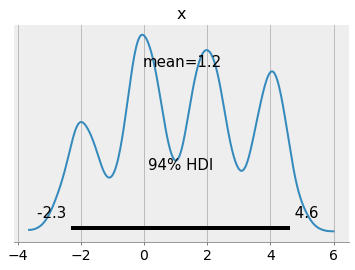

In [5]:
az.plot_posterior(mcmc, var_names=["x"]);

### Discrete HMC within Gibbs

In [6]:
kernel = DiscreteHMCGibbs(NUTS(model), modified=True)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=7000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

In [7]:
mcmc.print_summary()
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.56      0.89      2.00      0.00      3.00    112.00      1.00
         x      1.12      1.82      1.25     -2.12      4.19    112.78      1.00



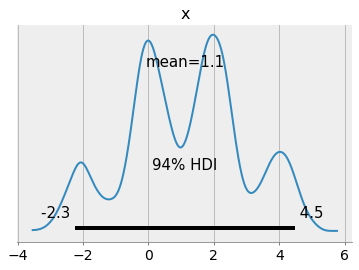

In [8]:
az.plot_posterior(mcmc, var_names=["x"]);

### HMC with marginalized discrete variable

In [9]:
def model_m(probs, locs):
     c = numpyro.sample("c", dist.Categorical(probs), infer={'enumerate': 'parallel'})
     numpyro.sample("x", dist.Normal(locs[c], 0.5))
    
probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])

In [10]:
kernel = NUTS(model_m)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=7000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

In [11]:
mcmc.print_summary()
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      1.23      2.12      1.41     -2.12      4.51    335.01      1.00

Number of divergences: 0


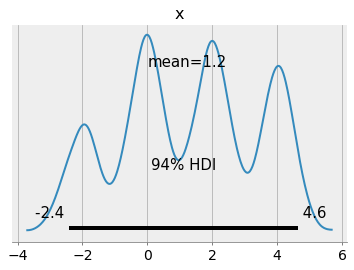

In [12]:
az.plot_posterior(mcmc, var_names=["x"]);

### Ground truth

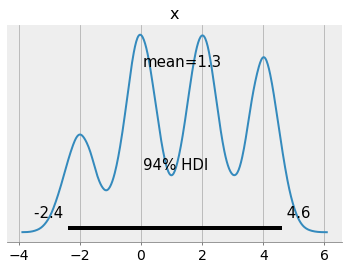

In [13]:
kernel = NUTS(model_m)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=100000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

az.plot_posterior(mcmc, var_names=["x"]);

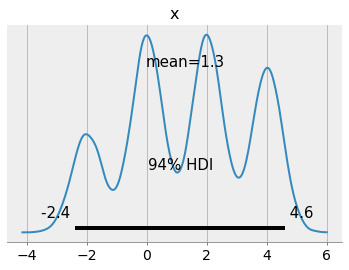

In [14]:
kernel = MixedHMC(HMC(model, trajectory_length=1.2), num_discrete_updates=20)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=100000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

az.plot_posterior(mcmc, var_names=["x"]);

## Mixed HMC implementation in Bean Machine

In [6]:
import beanmachine.ppl as bm
from beanmachine.ppl.experimental.mixedhmc import inference as mix
import torch.distributions as dist
import torch

In [4]:
@bm.random_variable
def c():
    probs = torch.tensor([0.15, 0.3, 0.3, 0.25])
    return dist.Categorical(probs)

@bm.random_variable
def x():
    locs = torch.tensor([-2., 0., 2., 4.])
    return dist.Normal(locs[c()], 0.5)

In [7]:
samples = mix.MixedHMC(max_step_size=1.0, num_discrete_updates=5, trajectory_length=1.0).infer(
    queries=[x()],
    observations={},
    num_adaptive_samples=1000,
    num_samples=7000,
)
    

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

In [8]:
import arviz as az

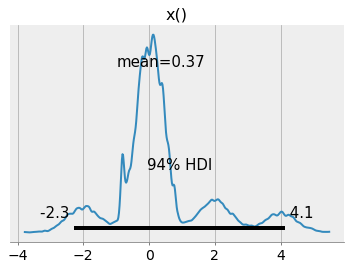

In [10]:
az.plot_posterior(samples.to_inference_data());

## Compositional Inference in Bean Machine

In [11]:
samples = bm.CompositionalInference().infer(
    queries=[x()],
    observations={},
    num_adaptive_samples=1000,
    num_samples=7000,
)


Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/8000 [00:00<?, ?it/s]

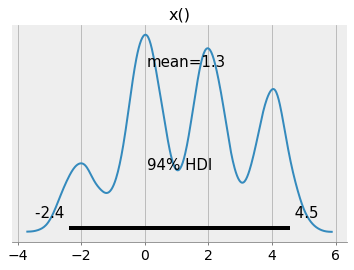

In [12]:
az.plot_posterior(samples.to_inference_data());